In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from copy import deepcopy
import torch

# Auxiliary functions

In [2]:
def plot(img):
    plt.imshow(img, cmap="gray")
    plt.show()

def squared_norm(u: np.ndarray) -> np.float32:
    u_flatten = u.flatten()
    return np.dot(u_flatten, u_flatten)

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

def RMSE(img1, img2):
  rmse = np.sum((img1 - img2) ** 2) / (np.shape(img1)[0] * np.shape(img1)[1])
  return np.sqrt(rmse)

def PSNR(img1, img2, max_bit=255):
  return 20 * np.log10(max_bit/RMSE(img1,img2))

def diff(img1, img2):
  return np.max(np.abs(img1 - img2))

def fft(img):
    if isinstance(img, np.ndarray):
        return np.fft.fft2(img)
    else:
        return torch.fft.fft2(img)

def ifft(img):
  if isinstance(img, np.ndarray):
    return np.fft.ifft2(img).real
  else:
    return torch.fft.ifft2(img).real

# Derivative functions

def D(img, axis):
  if isinstance(img, np.ndarray):
    return np.roll(img, -1, axis) - img
  else:
    return torch.roll(img, -1, axis) - img

def Dx(img):
  return D(img, 1)

def Dy(img):
  return D(img, 0)

def D_transpose(img, axis):
  if isinstance(img, np.ndarray):
    return np.roll(img, 1, axis) - img
  else:
    return torch.roll(img, 1, axis) - img

def Dx_transpose(img):
  return D_transpose(img, 1)

def Dy_transpose(img):
  return D_transpose(img, 0)

def grad(img):
  return np.array([Dx(img), Dy(img)])

def laplacian(img):
  return - Dx_transpose(Dx(img)) - Dy_transpose(Dy(img))

In [3]:
img = io.imread("lena.tif", as_gray=True)
img = img.astype(np.float32)

img_noise = (img + np.random.randn(*img.shape) * 40) / 255
param_lambda = 1

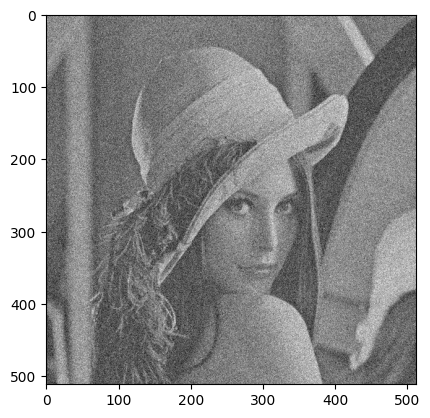

In [4]:
plot(img_noise)

# Analytical solution

Fourier Transform

In [5]:
def L(M, N):
  xi = np.arange(M)
  zeta = np.arange(N)

  X = np.square(np.sin((np.pi * xi) / M))
  Y = np.square(np.sin((np.pi * zeta) / N))

  return 4 * (X.reshape(M, 1) + Y.reshape(1, N))

def u_chapeau(v: np.ndarray, param_lambda: float) -> np.ndarray:
  N, M = v.shape
  return v / (1 + 2 * param_lambda * L(M, N))

In [6]:
def analytical_tychonov(img: np.ndarray, param_lambda: float) -> np.ndarray:
    img_fft = fft(img)
    u = u_chapeau(img_fft, param_lambda)
    return normalize(ifft(u))

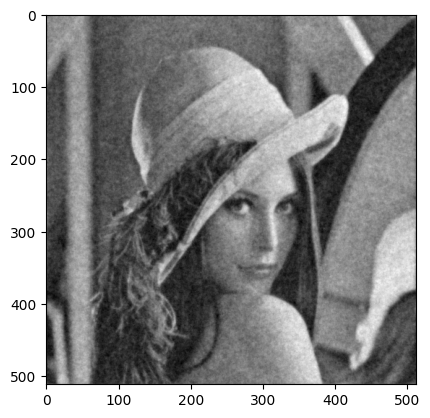

In [7]:
analytical_sol = analytical_tychonov(img_noise, param_lambda)
plot(analytical_sol)

# Numerical solution

In [8]:
def gradient_descent(F, grad_F, x_shape, x_init=None, tau=0.01, delta=1e-3, max_iter=10_000) -> np.ndarray:
    if x_init is None:
        x_init = np.random.rand(*x_shape)
    else:
        x_init = deepcopy(x_init)

    iters = 0
    x = x_init
    delta_x = tau * grad_F(x)
    F_values = [F(x)]

    while iters < max_iter and np.max(np.abs(delta_x)) > delta:
        x -= delta_x
        delta_x = tau * grad_F(x)
        F_values.append(F(x))

        iters += 1
    return x, F_values

## Tychonov

In [9]:
def F_tychonov(u: np.ndarray, v: np.ndarray, param_lambda: float):
    return squared_norm(u - v) / 2 + param_lambda * squared_norm(grad(u))

def grad_tychonov(u: np.ndarray, v: np.ndarray, param_lambda: float):
    return u - v - 2 * param_lambda * laplacian(u)

def numerical_tychonov(img: np.ndarray, param_lambda: float = 1):
    def F(u):
        return F_tychonov(u, img, param_lambda)

    def dF(u):
        return grad_tychonov(u, img, param_lambda)

    return gradient_descent(F, dF, img.shape)

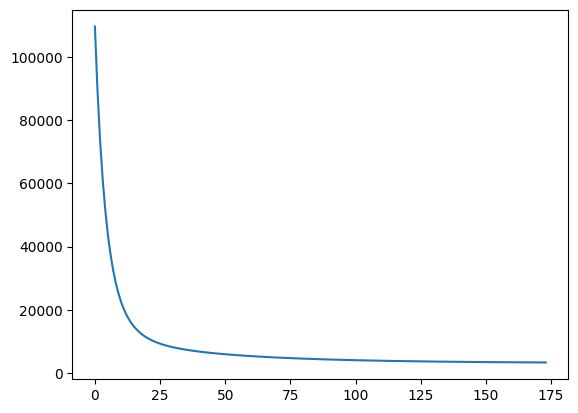

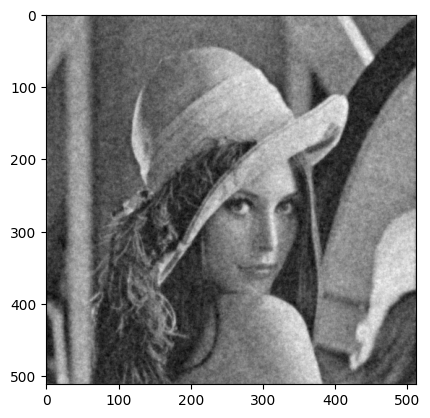

In [10]:
numerical_sol, F_values = numerical_tychonov(img_noise, param_lambda)
numerical_sol = normalize(numerical_sol)

plt.plot(np.arange(len(F_values)), F_values)
plt.show()
plot(numerical_sol)

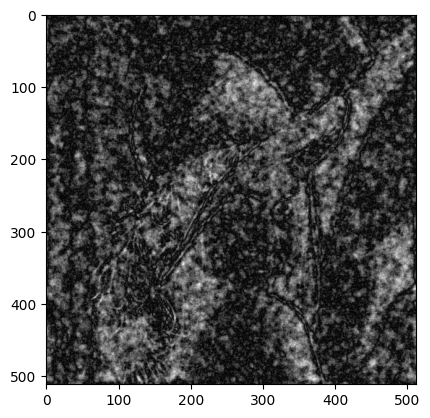

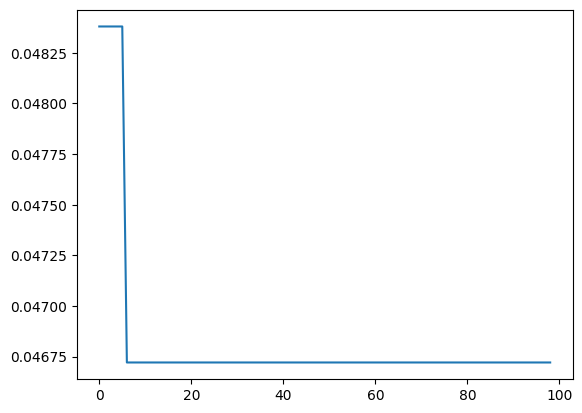

0.048380245038960545


In [11]:
plot(np.abs(analytical_sol - numerical_sol))

diffs = [diff(analytical_sol[i: -i, i: -i], numerical_sol[i: -i, i: -i]) for i in range(1, 100)]

plt.plot(np.arange(len(diffs)), diffs)
plt.show()

print(diff(analytical_sol, numerical_sol))

## TV

In [11]:
def F_TV(u: np.ndarray, v: np.ndarray, epsilon: float, param_lambda: float):
    return squared_norm(u - v) / 2 + param_lambda * np.sum(np.sqrt(np.square(epsilon) + np.square(Dx(u)) + np.square(Dy(u))))

def grad_TV(u: np.ndarray, v: np.ndarray, epsilon: float, param_lambda: float):
    g = grad(u)
    g /= np.sqrt(epsilon ** 2 + squared_norm(g))

    return u - v + param_lambda * (Dx_transpose(g[0]) + Dy_transpose(g[1]))

def total_variation(img: np.ndarray, epsilon: float = 1e-4, param_lambda: float = 1):
    def F(u):
        return F_TV(u, img, epsilon, param_lambda)

    def dF(u):
        return grad_TV(u, img, epsilon, param_lambda)

    return gradient_descent(F, dF, img.shape, tau=0.01, delta=1e-5, max_iter=10_000)

In [12]:
epsilon = 1e-2

numerical_sol, F_values = total_variation(img_noise, epsilon, 40)
numerical_sol = normalize(numerical_sol)

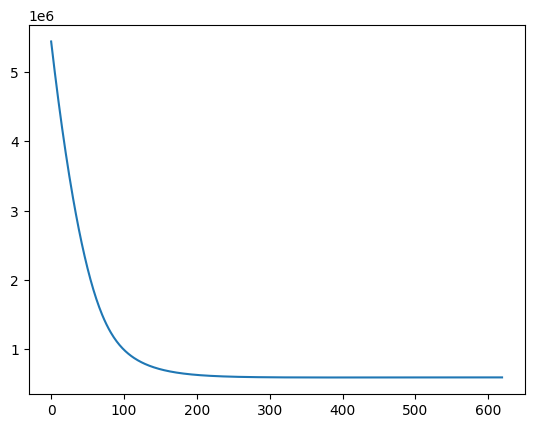

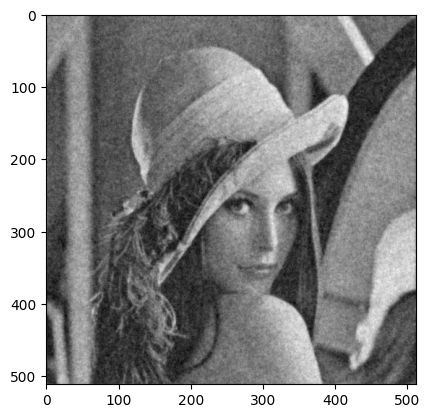

In [13]:
y = F_values
plt.plot(np.arange(len(y)), y)
plt.show()
plot(numerical_sol)

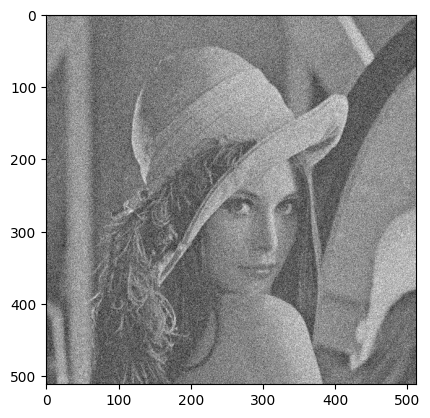

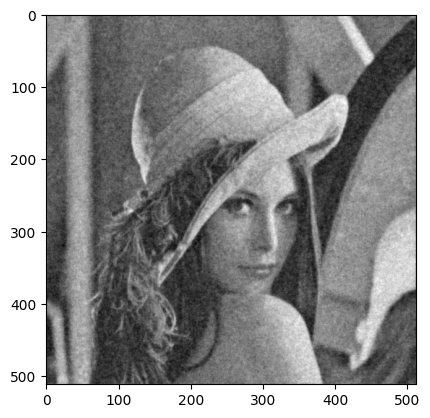

In [15]:
plot(img_noise)
plot(numerical_sol)

In [14]:
print(len(F_values), F_values[-1])

np.argmin(F_values)

620 592210.434925977


np.int64(395)

In [15]:
diff(numerical_sol, img_noise)

np.float64(0.7064670479692545)

# Using PyTorch

In [16]:
def sgd(f, x0, tau=1e-2, delta=1e-4, max_iter=10_000):
    x = x0.clone().requires_grad_(True)
    optim = torch.optim.SGD([x], lr=tau)

    y = []
    iters = 0

    while iters < max_iter:
        optim.zero_grad()

        x_prev = x.clone()

        loss = f(x)
        y.append(loss.item())

        loss.backward()

        optim.step()

        if torch.max(torch.abs(x - x_prev)).item() < delta:
            break

        iters += 1
    return x.detach().numpy(), y

In [21]:
def blur_kernel(A, u):
    if A is None:
      A = torch.zeros((3, 3))
      A[1, 1] = 1

    if isinstance(A, np.ndarray):
      A = torch.tensor(A)

    N, M = u.shape
    H, W = A.shape
    k = torch.zeros((N,M))
    k[0:H,0:W] = A/torch.sum(A)
    k = torch.roll(k,(-int(H/2),-int(W/2)),(0,1))
    return k

def conv_img(img, A):
    kernel = blur_kernel(A, img)
    if isinstance(img, np.ndarray):
      return ifft(fft(kernel)*fft(img)).real
    else:
      return ifft(fft(kernel)*fft(img)).real


def F_tychonov(u, v, param_lambda: float, A=None):
    # if A is None:
    #     A = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
    # data_fidelity = (torch.sum((conv_img(u,A) - v) ** 2)) / 2       #A is the matrix with the blur
    # data_fidelity = (torch.sum((u - v) ** 2)) / 2
    data_fidelity = (torch.norm(conv_img(u, A) - v) ** 2) / 2
    
    dx, dy = Dx(u), Dy(y)
    grad_u = torch.norm(dx) ** 2 + torch.norm(dy) ** 2

    regularization = param_lambda * grad_u

    return data_fidelity + regularization

def tychonov(img, param_lambda, A=None):
    return lambda x: F_tychonov(x, img, param_lambda)

def F_TV(u: np.ndarray, v: np.ndarray, epsilon: float, param_lambda: float, A=None):
    # data_fidelity = (torch.sum((conv_img(u,A) - v) ** 2)) / 2
    data_fidelity = (torch.norm(u - v) ** 2) / 2
    dx, dy = Dx(u), Dy(u)

    regularization = param_lambda * torch.sum(torch.sqrt(epsilon ** 2 + dx.flatten() ** 2 + dy.flatten() ** 2))

    return data_fidelity + regularization

def tv(img, epsilon, param_lambda, A=None):
    return lambda x: F_TV(x, img, epsilon, param_lambda, A = A)

In [22]:
img = io.imread("lena.tif", as_gray=True)
A = np.loadtxt('levin1.txt')
img = img.astype(np.float32)

img_noise = (conv_img(img, A) + np.random.randn(*img.shape) * 40) / 255

v = torch.tensor(img_noise)

/var/folders/81/3v_d9rcn7wd1szht19l1v89c0000gn/T/ipykernel_65907/2892943955.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return ifft(fft(kernel)*fft(img)).real
/var/folders/81/3v_d9rcn7wd1szht19l1v89c0000gn/T/ipykernel_65907/2152050424.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img_noise = (conv_img(img, A) + np.random.randn(*img.shape) * 40) / 255
/var/folders/81/3v_d9rcn7wd1szht19l1v89c0000gn/T/ipykernel_65907/2152050424.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(img_noise)


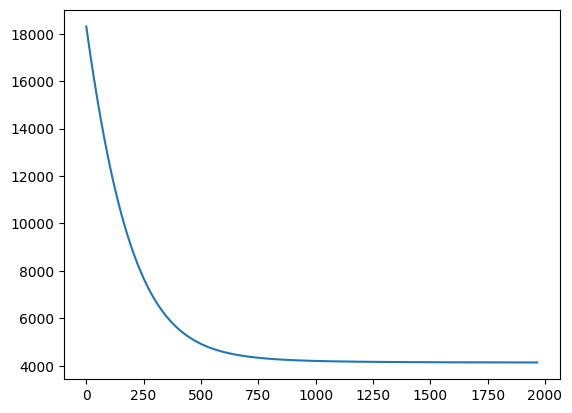

In [56]:
x, Y = sgd(tv(v, 1e-3, 0.25), v)

plt.plot(Y)
plt.show()

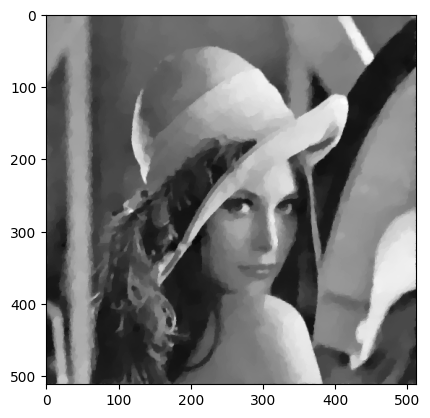

In [52]:
plot(x)

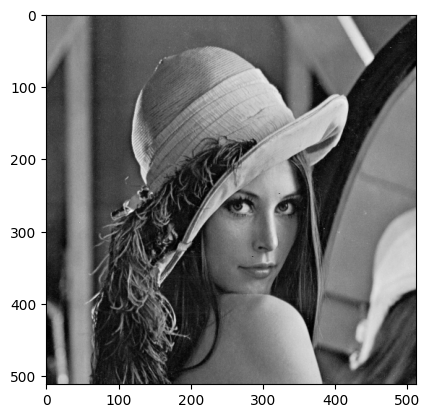

In [102]:
new_img = conv_img(img,None)
plot(new_img)

In [103]:
x, Y = sgd(tychonov(img_blur, 0.25), img_blur)
plot(x)

KeyboardInterrupt: 

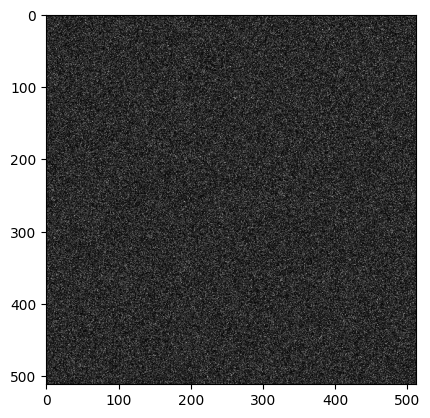

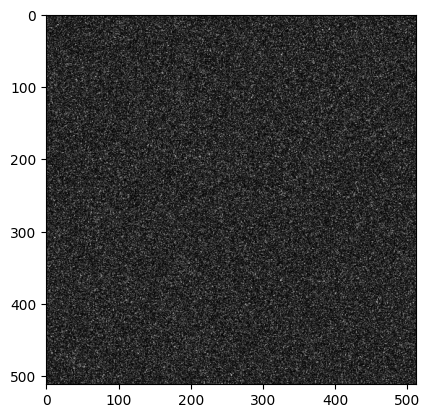

In [25]:
plot(np.abs(img / 255 - x))
plot(np.abs(img_noise - x))

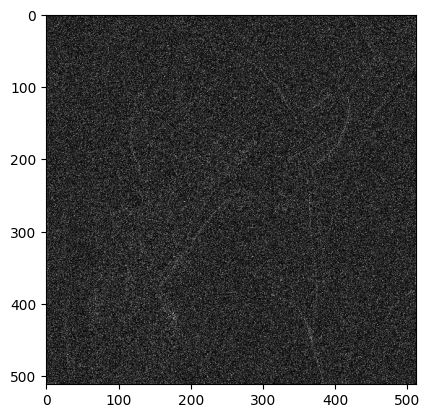

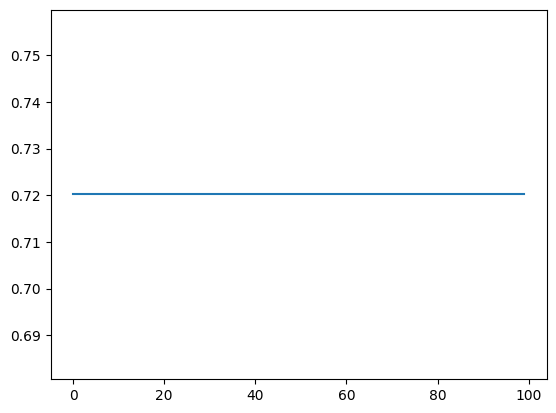

183.6446041354568


In [26]:
plot(np.abs(analytical_sol - x))

diffs = [diff(analytical_sol[i: -i, i: -i], x[i: -i, i: -i]) for i in range(1, 100)]
diffs.insert(0, diff(analytical_sol, x))

plt.plot(np.arange(len(diffs)), diffs)
plt.show()

print(diffs[5] * 255)